# Analysing CosMx data Python

## Load required enviroment with packages installed

In [1]:
import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/projects/g/gilberts-spatial-biology-image-analysis/Chris/my-virtual-env-icelake'  # edit this line to match the venv directory format
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import spatialdata as sd
from spatialdata_io import xenium
import spatialdata_plot
import dill
import anndata as ad
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint
from shapely.ops import unary_union, triangulate
import os
import multiprocessing as mp
from tqdm import tqdm
import numpy as np
from scipy.sparse import csr_matrix

/rds/bear-apps/2022a/EL8-ice/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Read in data and make sure there are x/y/cell columns

In [2]:
Patient1_tx_file = pd.read_csv("/rds/projects/g/gilberts-spatial-biology-image-analysis/CosMx/Liver/Patient1/Patient1_tx_file.csv")
Patient1_tx_file['x'] = Patient1_tx_file['x_global_px']
Patient1_tx_file['y'] = Patient1_tx_file['y_global_px']
Patient1_tx_file['cell'] = Patient1_tx_file['cell_ID']
Patient1_tx_file['cell'] = Patient1_tx_file['cell_ID'].astype(str) + '_' + Patient1_tx_file['fov'].astype(str)
Patient1_tx_file


/tmp/ipykernel_3562304/2335509441.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  Patient1_tx_file = pd.read_csv("/rds/projects/g/gilberts-spatial-biology-image-analysis/CosMx/Liver/Patient1/Patient1_tx_file.csv")


fov  cell_ID      cell  x_local_px  y_local_px   x_global_px  \
0            1        0       0_1        4256        1349  11695.539637   
1            1        0       0_1        4255        1590  11694.820105   
2            1        0       0_1        4255        1592  11694.910294   
3            1        0       0_1        4255        1595  11694.830016   
4            1        0       0_1        4255        1603  11694.999493   
...        ...      ...       ...         ...         ...           ...   
142327249  217     1205  1205_217        3483        4217  90167.596585   
142327250  217     1205  1205_217        3477        4224  90161.348751   
142327251  217     1205  1205_217        3476        4253  90161.293250   
142327252  217     1205  1205_217        3472        4224  90156.417085   
142327253  217     1205  1205_217        3471        4237  90155.695571   

             y_global_px  z            target   CellComp             x  \
0          120700.824106  6          TNFRSF18        NaN  11695.539637   
1          120460.472792  0               LEP        NaN  11694.820105   
2          120457.943529  0             APOC1        NaN  11694.910294   
3          120455.287407  0              APOE        NaN  11694.830016   
4          120447.255610  0             APOA1        NaN  11694.999493   
...                  ... ..               ...        ...           ...   
142327249   48121.200961  5  SystemControl150  Cytoplasm  90167.596585   
142327250   48113.648852  2  SystemControl136  Cytoplasm  90161.348751   
142327251   48084.879480  1   SystemControl15    Nuclear  90161.293250   
142327252   48114.299008  7   SystemControl41  Cytoplasm  90156.417085   
142327253   48101.331581  2  SystemControl197  Cytoplasm  90155.695571   

                       y  
0          120700.824106  
1          120460.472792  
2          120457.943529  
3          120455.287407  
4          120447.255610  
...                  ...  
142327249   48121.200961  
142327250   48113.648852  
142327251   48084.879480  
142327252   48114.299008  
142327253   48101.331581  

[142327254 rows x 12 columns]

## (optional) now subset the first 10 FOVs to reduce file size and increase speed for this example

In [3]:
fovs = [Patient1_tx_file[Patient1_tx_file['fov'] == fov] for fov in Patient1_tx_file['fov'].unique()]
fovs = [Patient1_tx_file[Patient1_tx_file['fov'] == fov] 
            for fov in Patient1_tx_file['fov'].unique()[:10]]

fovs[1]

fov  cell_ID    cell  x_local_px  y_local_px   x_global_px  \
854550     2        0     0_2        4256         516  15951.619764   
854551     2        0     0_2        4256         601  15951.509753   
854552     2        0     0_2        4256         700  15951.580120   
854553     2        0     0_2        4256        1473  15951.580120   
854554     2        0     0_2        4256        1783  15951.739686   
...      ...      ...     ...         ...         ...           ...   
1754696    2     1180  1180_2        2674        4237  14369.609557   
1754697    2     1180  1180_2        2671        4246  14367.029749   
1754698    2     1180  1180_2        2637        4213  14332.899569   
1754699    2     1180  1180_2        2626        4207  14321.800348   
1754700    2     1180  1180_2        2598        4219  14293.800062   

           y_global_px  z            target   CellComp             x  \
854550   121534.220128  6             RAMP1        NaN  15951.619764   
854551   121449.485864  6             APOA1        NaN  15951.509753   
854552   121350.479897  6             NEAT1        NaN  15951.580120   
854553   120577.239098  6            MALAT1        NaN  15951.580120   
854554   120267.598672  5               VTN        NaN  15951.739686   
...                ... ..               ...        ...           ...   
1754696  117813.183125  5   SystemControl18    Nuclear  14369.609557   
1754697  117804.057165  4  SystemControl148    Nuclear  14367.029749   
1754698  117837.452947  1   SystemControl24  Cytoplasm  14332.899569   
1754699  117843.478776  5   SystemControl73  Cytoplasm  14321.800348   
1754700  117831.339901  8  SystemControl177  Cytoplasm  14293.800062   

                     y  
854550   121534.220128  
854551   121449.485864  
854552   121350.479897  
854553   120577.239098  
854554   120267.598672  
...                ...  
1754696  117813.183125  
1754697  117804.057165  
1754698  117837.452947  
1754699  117843.478776  
1754700  117831.339901  

[900151 rows x 12 columns]

## Now load and define a function to draw cells based on tx assingment

In [4]:
import geopandas as gpd
from shapely.geometry import MultiPoint
from shapely.ops import unary_union, triangulate
from multiprocessing import Pool

def process_cell(cell_group):
    cell, cell_data = cell_group
    points = MultiPoint(cell_data[['x', 'y']].values)
    union = unary_union(points)
    triangles = triangulate(union)
    geometry = unary_union(triangles)
    return {'cell': cell, 'geometry': geometry}

def cellgeoms_draw(segfile):
    # Calculate the number of transcripts per cell
    transcriptspercell = segfile.groupby('cell').size().reset_index(name='num_transcripts')
    
    # Filter cells with more than 5 transcripts
    filtered_cells = transcriptspercell[transcriptspercell['num_transcripts'] > 5]
    cellidx = filtered_cells['cell'].unique()
    
    # Filter the data for relevant cells only
    filtered_segfile = segfile[segfile['cell'].isin(cellidx)]

    # Group data by cell
    grouped = filtered_segfile.groupby('cell')
    
    # Process cells in parallel
    with Pool() as pool:
        geometries = pool.map(process_cell, grouped)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometries, geometry='geometry')
    gdf['num_transcripts'] = gdf['cell'].map(transcriptspercell.set_index('cell')['num_transcripts'])
    
    return gdf



cellgeoms_all = []
for i in range(len(fovs)):  
    cellgeoms = cellgeoms_draw(fovs[i])
    cellgeoms_all.append(cellgeoms)


cellgeoms_all_concat = pd.concat(cellgeoms_all, ignore_index=True)

cellgeoms_all_concat


cell                                           geometry  \
0         0_1  POLYGON ((7440.217 121721.322, 7440.288 121758...   
1      1000_1  POLYGON ((11482.5 118526.633, 11496.6 118528.1...   
2      1001_1  POLYGON ((10541.5 118510.847, 10566.31 118510....   
3      1002_1  POLYGON ((11229.31 118490.019, 11231.1 118491....   
4      1003_1  POLYGON ((10448.05 118498.185, 10455.809 11850...   
...       ...                                                ...   
10963  997_10  POLYGON ((27811.321 113658.857, 27813.019 1136...   
10964  998_10  POLYGON ((28028.251 113612.268, 28031.749 1136...   
10965  999_10  POLYGON ((28212.409 113681.169, 28251.579 1137...   
10966   99_10  POLYGON ((25500.599 117449.516, 25503.86 11745...   
10967    9_10  POLYGON ((26321.25 117667.318, 26305.18 117731...   

       num_transcripts  
0                14258  
1                 1673  
2                  953  
3                 1033  
4                  476  
...                ...  
10963             1409  
10964              925  
10965              393  
10966             1033  
10967             1525  

[10968 rows x 3 columns]

## Now lets plot FOVs to check all looks OK

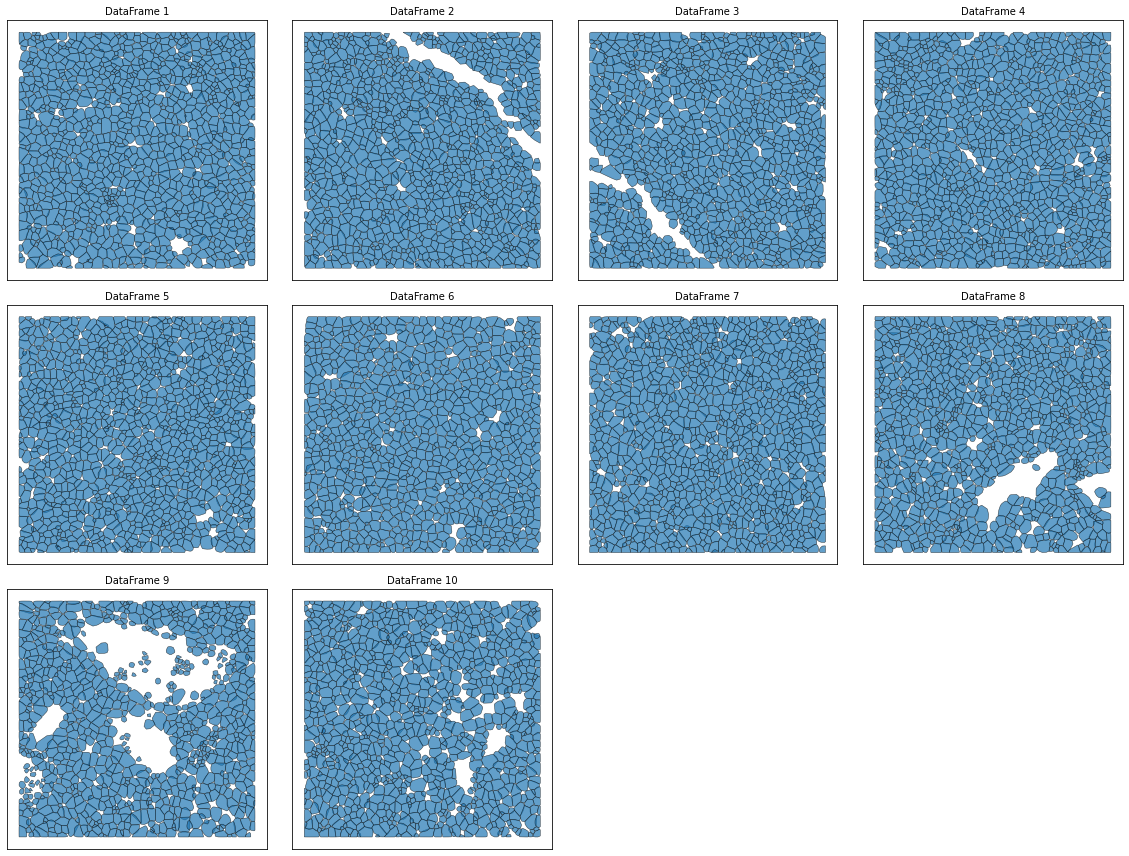

In [5]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Number of columns in the grid
cols = 4
# Calculate the number of rows needed
rows = -(-len(cellgeoms_all) // cols)  # Ceiling division

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))  # Adjust size based on rows

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through each GeoDataFrame and plot
for i, cell_geom in enumerate(cellgeoms_all):
    # Create a GeoDataFrame from the current DataFrame
    gdf = gpd.GeoDataFrame(cell_geom, geometry='geometry')
    
    # Remove rows where 'cell' starts with '0_'
    gdf = gdf[~gdf['cell'].astype(str).str.startswith('0_')]
    
    # Plot on the respective subplot
    ax = axes[i]
    gdf.plot(ax=ax, alpha=0.7, legend=False, edgecolor='black', linewidth=0.5)
    
    # Set the title for the subplot
    ax.set_title(f'DataFrame {i + 1}', fontsize=10)
    
    # Remove x and y axis labels for cleaner visuals
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('white')
    ax.set_aspect('equal')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Delete unused axes

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


## Now plot all FOVs in a single plot

     cell                                           geometry  num_transcripts
1  1000_1  POLYGON ((11482.5 118526.633, 11496.6 118528.1...             1673
2  1001_1  POLYGON ((10541.5 118510.847, 10566.31 118510....              953
3  1002_1  POLYGON ((11229.31 118490.019, 11231.1 118491....             1033
4  1003_1  POLYGON ((10448.05 118498.185, 10455.809 11850...              476
5  1004_1  POLYGON ((7737.2 118452.833, 7737.2 118459.136...              326


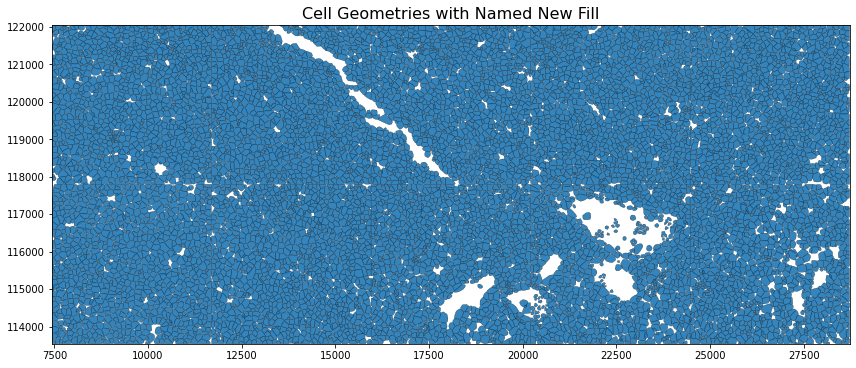

In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

# Combine the first 10 DataFrames into a single DataFrame
combined_df = pd.concat(cellgeoms_all)

# Convert the 'geometry' column to proper geometric objects if needed (commented as your data seems already converted)
#combined_df['geometry'] = combined_df['geometry'].apply(wkt.loads)

# Convert the combined DataFrame into a GeoDataFrame
gdf_combined = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Remove any rows where 'cell' starts with '0_'
gdf_combined = gdf_combined[~gdf_combined['cell'].astype(str).str.startswith('0_')]

# Check the first few rows to make sure the data is as expected
print(gdf_combined.head())  # Debug step: see if the data looks correct

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 12))

# Set the axis background to white
ax.set_facecolor('white')

# Plot the geometries with fill based on 'cell_types' column
gdf_combined.plot(ax=ax, alpha=0.9, legend=True, edgecolor='black', linewidth=0.25)

# Customize the title and other aesthetics
ax.set_title('Cell Geometries with Named New Fill', color='black', fontsize=16)

# Set the figure background to transparent (optional)
fig.patch.set_alpha(0)

# Set limits and aspect ratio for better visualization
ax.set_xlim(gdf_combined.total_bounds[[0, 2]])  # x limits
ax.set_ylim(gdf_combined.total_bounds[[1, 3]])  # y limits
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()

## Now lets color cell by num transcripts

     cell                                           geometry  num_transcripts
1  1000_1  POLYGON ((11482.5 118526.633, 11496.6 118528.1...             1673
2  1001_1  POLYGON ((10541.5 118510.847, 10566.31 118510....              953
3  1002_1  POLYGON ((11229.31 118490.019, 11231.1 118491....             1033
4  1003_1  POLYGON ((10448.05 118498.185, 10455.809 11850...              476
5  1004_1  POLYGON ((7737.2 118452.833, 7737.2 118459.136...              326


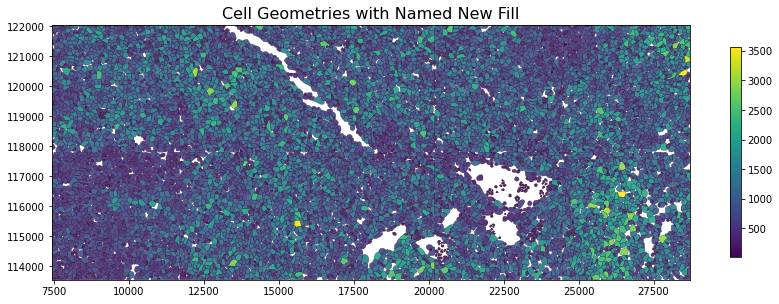

In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

# Combine the first 10 DataFrames into a single DataFrame
combined_df = pd.concat(cellgeoms_all)

# Convert the combined DataFrame into a GeoDataFrame
gdf_combined = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Remove any rows where 'cell' starts with '0_'
gdf_combined = gdf_combined[~gdf_combined['cell'].astype(str).str.startswith('0_')]

# Check the first few rows to make sure the data is as expected
print(gdf_combined.head())  # Debug step: see if the data looks correct

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 12))

# Set the axis background to white
ax.set_facecolor('white')

# Plot the geometries with fill based on 'num_transcripts' column and adjust scale bar size
gdf_combined.plot(
    ax=ax,
    column='num_transcripts',
    alpha=0.9,
    legend=True,
    edgecolor='black',
    linewidth=0.25,
    legend_kwds={'shrink': 0.25}  # Adjust the shrink factor to make the scale bar smaller
)

# Customize the title and other aesthetics
ax.set_title('Cell Geometries with Named New Fill', color='black', fontsize=16)

# Set the figure background to transparent (optional)
fig.patch.set_alpha(0)

# Set limits and aspect ratio for better visualization
ax.set_xlim(gdf_combined.total_bounds[[0, 2]])  # x limits
ax.set_ylim(gdf_combined.total_bounds[[1, 3]])  # y limits
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()


## Now make count matrices based on tx for each FOV and create an anndata object

In [8]:
def mk_count_mtx(genes, cells, remove_bg=True):
    # Filter out background cells if required
    if remove_bg:
        valid_mask = cells != 0
        genes = genes[valid_mask]
        cells = cells[valid_mask]

    # Factorize the genes and cells (faster than Categorical conversion)
    gene_codes, gene_categories = pd.factorize(genes)
    cell_codes, cell_categories = pd.factorize(cells)

    # Create the sparse count matrix efficiently
    counts = csr_matrix(
        (np.ones_like(gene_codes), (gene_codes, cell_codes)),
        shape=(len(gene_categories), len(cell_categories))
    )

    # Convert to a sparse pandas DataFrame and set row and column names
    counts_df = pd.DataFrame.sparse.from_spmatrix(counts, 
                                                  index=gene_categories, 
                                                  columns=cell_categories)

    return counts_df


count_matrices = []
for i in range(len(fovs)):
    filtered_fov = fovs[i][~fovs[i]['target'].str.contains('SystemControl|Negative')]
    filtered_fov = filtered_fov[~filtered_fov['cell'].astype(str).str.startswith('0_')]
    count_matrix = mk_count_mtx(genes=filtered_fov['target'].values, cells=filtered_fov['cell'].values)
    count_matrices.append(count_matrix)


anndata_list = []
for i, count_matrix in enumerate(count_matrices):
    adata = ad.AnnData(X=count_matrix.T)
    adata.obs['sample_name'] = f'FOV_{i+1}'
    anndata_list.append(adata)

combined_adata = ad.concat(anndata_list, axis=0)

combined_adata

AnnData object with n_obs × n_vars = 10958 × 1000
    obs: 'sample_name'

## Next for feeding this data into squidpy or just general plotting, calculate area and x/y centroid 

## Note: this code remove the smallest 10% of cells

In [9]:
if 'area' in combined_adata.obs:
    del combined_adata.obs['area']

if 'spatial' in combined_adata.obsm:
    del combined_adata.obsm['spatial']


combined_FOVs = pd.concat(fovs, ignore_index=True)


centroids_new = combined_FOVs.groupby('cell').agg({'x_global_px': 'mean', 'y_global_px': 'mean'}).reset_index()
combined_adata.obs['cell_ID'] = combined_adata.obs.index
centroids_new['cell'] = centroids_new['cell'].astype(str)
coord_dict = centroids_new.set_index('cell')[['x_global_px', 'y_global_px']].to_dict(orient='index')
spatial_coordinates = np.full((combined_adata.n_obs, 2), np.nan)

assigned_coords = 0
for cell, coords in coord_dict.items():
    if cell in combined_adata.obs.index:
        spatial_coordinates[combined_adata.obs.index.get_loc(cell)] = [coords['x_global_px'], coords['y_global_px']]
        assigned_coords += 1

cellgeoms_all_concat['fov'] = cellgeoms_all_concat['cell']
cellgeoms_all_concat[['fov_part1', 'fov']] = cellgeoms_all_concat['fov'].str.split('_', expand=True)
cellgeoms_all_concat = cellgeoms_all_concat.drop(columns=['fov_part1'])

combined_adata.obsm['spatial'] = spatial_coordinates

import geopandas as gpd
from shapely import wkt

#cellgeoms_all_concat['geometry'] = cellgeoms_all_concat['geometry'].apply(wkt.loads)
cellgeoms_all_concat['area'] = cellgeoms_all_concat['geometry'].apply(lambda geom: geom.area)
area_df = cellgeoms_all_concat[['cell', 'area']]
area_df.set_index('cell', inplace=True)
combined_adata.obs = combined_adata.obs.merge(area_df, left_index=True, right_index=True, how='left')
Q1 = combined_adata.obs['area'].quantile(0.10)
mask = (combined_adata.obs['area'] >= Q1)
combined_adata = combined_adata[mask].copy()


if 'area' not in combined_adata.obs and 'spatial' not in combined_adata.obsm:
    print("Error: Either 'area' in obs or 'spatial' in obsm does not exist in combined_adata.")
else:
    print("'area' in obs and 'spatial' in obsm exist. Continuing...")
    # Continue with further processing


combined_adata

'area' in obs and 'spatial' in obsm exist. Continuing...


AnnData object with n_obs × n_vars = 9862 × 1000
    obs: 'sample_name', 'cell_ID', 'area'
    obsm: 'spatial'

## Now lets have a look at the area distrobution and q10 cut off

<Figure size 576x432 with 0 Axes>

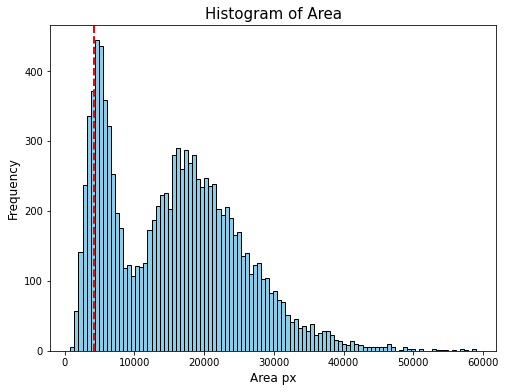

In [34]:


import pandas as pd
import matplotlib.pyplot as plt

filtered_area_df = area_df[~area_df.index.str.startswith('0_')]

quantile_0_1 = filtered_area_df['area'].quantile(0.1)

# Plot a histogram
plt.figure(figsize=(8, 6))

# Plot log-transformed histogram
plt.figure(figsize=(8, 6))
plt.hist(filtered_area_df['area'], bins=100, color='skyblue', edgecolor='black')

plt.axvline(x=quantile_0_1, color='red', linestyle='dashed', linewidth=2, label=f'0.1 Quantile: {quantile_0_1:.2f}')

# Add labels and title
plt.xlabel('Area px', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Area', fontsize=15)

# Show the plot
plt.show()


## Now lets QC the data - area is not considered here but also a paramter that can be used

Text(0, 0.5, 'Number of Cells')

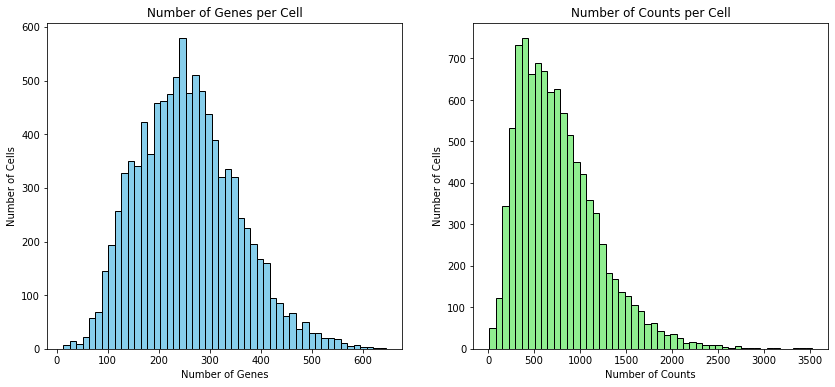

In [10]:
combined_adata.obs['total_counts'] = combined_adata.X.sum(axis=1)
combined_adata.obs['n_genes_by_counts'] = (combined_adata.X > 0).sum(axis=1)

# Calculate the number of genes per cell (non-zero values per cell)
genes_per_cell = (combined_adata.X > 0).sum(axis=1)

# Calculate the total counts per cell (sum of all counts per cell)
counts_per_cell = combined_adata.X.sum(axis=1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of number of genes per cell
axs[0].hist(genes_per_cell, bins=50, color='skyblue', edgecolor='black')
axs[0].set_title('Number of Genes per Cell')
axs[0].set_xlabel('Number of Genes')
axs[0].set_ylabel('Number of Cells')

# Plot histogram of counts per cell
axs[1].hist(counts_per_cell, bins=50, color='lightgreen', edgecolor='black')
axs[1].set_title('Number of Counts per Cell')
axs[1].set_xlabel('Number of Counts')
axs[1].set_ylabel('Number of Cells')



## And process the data

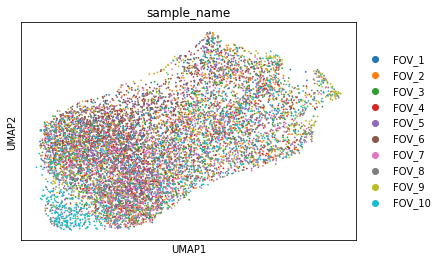

In [11]:
sc.pp.filter_cells(combined_adata, min_genes=75)
sc.pp.filter_genes(combined_adata, min_cells=5)
sc.pp.normalize_total(combined_adata, inplace=True)
sc.pp.log1p(combined_adata)
sc.pp.pca(combined_adata)
sc.pp.neighbors(combined_adata)
sc.external.pp.bbknn(combined_adata, batch_key="sample_name")
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color=["sample_name"])

## Now lets plot all the FOVs ( this is more useful when using all FOVs in a sample)

/tmp/ipykernel_716111/1454294253.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10', 10)  # Use 'tab10' which has 10 distinct colors


Text(0, 0.5, 'Y Coordinate')

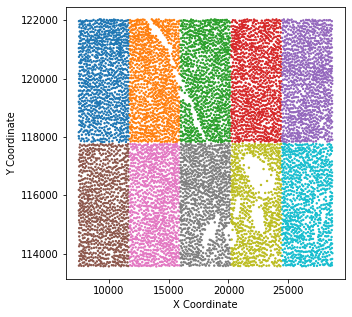

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Extract spatial coordinates
coords = combined_adata.obsm["spatial"]

# Extract sample names
sample_names = combined_adata.obs["sample_name"]

# Generate 10 distinct colors and repeat them over the samples
base_colors = plt.cm.get_cmap('tab10', 10)  # Use 'tab10' which has 10 distinct colors
num_samples = len(sample_names.unique())

# Create a repeated colormap by cycling the 10 base colors over all samples
repeated_colors = [base_colors(i % 10) for i in range(num_samples)]
custom_cmap = ListedColormap(repeated_colors)

# Create a scatter plot, coloring by sample names
plt.figure(figsize=(5, 5))
scatter = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=sample_names.astype('category').cat.codes, 
    cmap=custom_cmap, 
    s=2
)

# Label the axes
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")


## Now use Squidpy to find spatially varible gene using Morans statistic

  0%|          | 0/100 [00:00<?, ?/s]

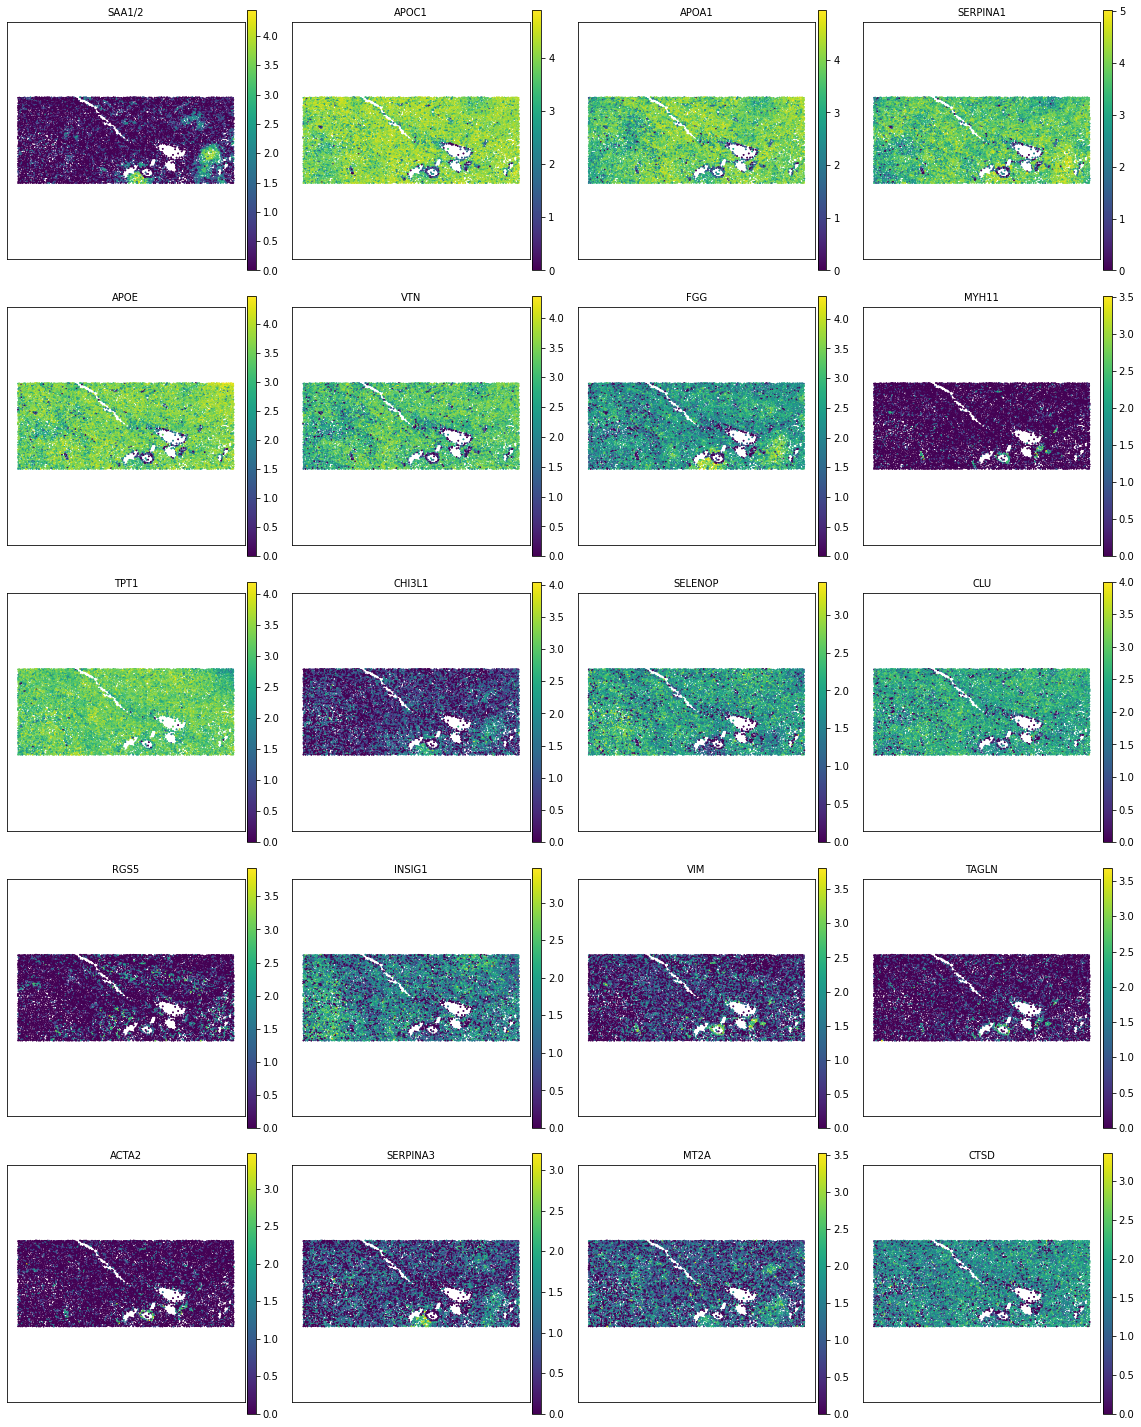

In [13]:
import matplotlib.pyplot as plt
import squidpy as sq
import math

# Assuming combined_adata is preprocessed and has spatial data
sq.gr.spatial_neighbors(combined_adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    combined_adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

# Get Moran's I results
moran_res = combined_adata.uns["moranI"]
top_genes = moran_res["I"].nlargest(20).index 

# Parameters for layout
n_cols = 4  # Number of plots per row
n_rows = math.ceil(len(top_genes) / n_cols)  # Number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten axes for easier indexing

# Plot each gene
for i, gene in enumerate(top_genes):
    ax = axes[i]
    sq.pl.spatial_scatter(
        combined_adata,
        library_id="spatial",
        color=[gene],
        shape=None,
        size=2,
        img=False,
        ax=ax  # Use the provided axes
    )
    ax.invert_yaxis()  # Flip vertically
    ax.set_box_aspect(1)  # Ensure equal aspect ratio for the axes
    ax.set_title(gene, fontsize=10)  # Add a title with the gene name
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

# Turn off any empty axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()  # Adjust spacing between plots
plt.show()


## Increase clustering resolution untill n cluster are found

In [14]:
resolution = 0.1
max_resolution = 2.0
step_size = 0.05  # Finer steps for resolution adjustment

while resolution <= max_resolution:
    sc.tl.louvain(combined_adata, resolution=resolution, key_added=f'louvain_{resolution:.2f}')
    num_clusters = combined_adata.obs[f'louvain_{resolution:.2f}'].nunique()
    print(f"Resolution: {resolution:.2f}, Number of clusters: {num_clusters}")
    
    if num_clusters == 3:
        print(f"Running sc.tl.rank_genes_groups for resolution {resolution:.2f}")
        sc.tl.rank_genes_groups(combined_adata, groupby=f'louvain_{resolution:.2f}', method='t-test')
        break
    
    resolution += step_size  # Use finer step size

if resolution > max_resolution:
    print("Did not find exactly 3 clusters within the given resolution range.")


Resolution: 0.10, Number of clusters: 1
Resolution: 0.15, Number of clusters: 2
Resolution: 0.20, Number of clusters: 2
Resolution: 0.25, Number of clusters: 2
Resolution: 0.30, Number of clusters: 2
Resolution: 0.35, Number of clusters: 2
Resolution: 0.40, Number of clusters: 2
Resolution: 0.45, Number of clusters: 3
Running sc.tl.rank_genes_groups for resolution 0.45


In [15]:
combined_adata

AnnData object with n_obs × n_vars = 9761 × 1000
    obs: 'sample_name', 'cell_ID', 'area', 'total_counts', 'n_genes_by_counts', 'n_genes', 'louvain_0.10', 'louvain_0.15', 'louvain_0.20', 'louvain_0.25', 'louvain_0.30', 'louvain_0.35', 'louvain_0.40', 'louvain_0.45'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_name_colors', 'spatial_neighbors', 'moranI', 'louvain_0.10', 'louvain_0.15', 'louvain_0.20', 'louvain_0.25', 'louvain_0.30', 'louvain_0.35', 'louvain_0.40', 'louvain_0.45', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

## Now lets look at the gene expression

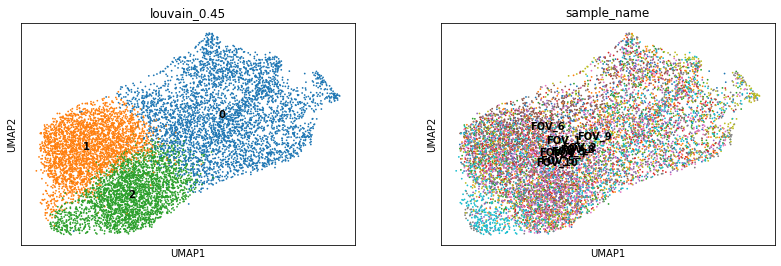

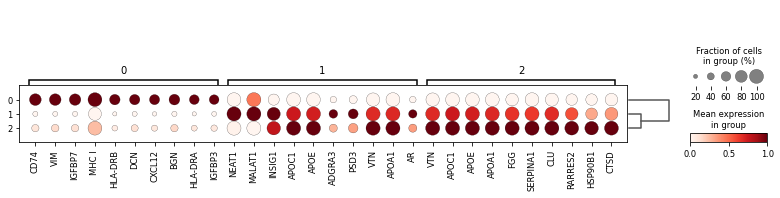

In [16]:
sc.pl.umap(
    combined_adata,
    color=["louvain_0.45", "sample_name"],
    legend_loc="on data",
)


sc.pl.rank_genes_groups_dotplot(
    combined_adata, groupby="louvain_0.45", standard_scale="var", n_genes=10
)


## And assing cell labels - these are dummy cell types

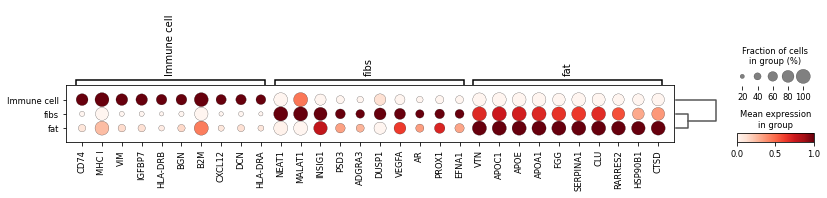

In [17]:
combined_adata.obs["cell_types"] = combined_adata.obs["louvain_0.45"].map(
    {
        "0": "Immune cell",
        "1": "fibs",
        "2": "fat",
            }
)

sc.tl.rank_genes_groups(combined_adata, groupby="cell_types", method="wilcoxon")


sc.pl.rank_genes_groups_dotplot(
    combined_adata, groupby="cell_types", standard_scale="var", n_genes=10
)


## And check where cells are in x/y space

/rds/projects/g/gilberts-spatial-biology-image-analysis/Chris/my-virtual-env-icelake/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/rds/projects/g/gilberts-spatial-biology-image-analysis/Chris/my-virtual-env-icelake/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


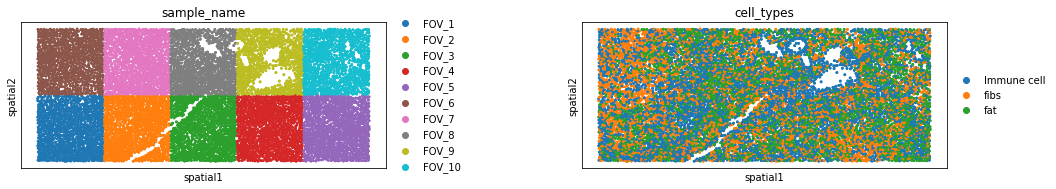

In [18]:
sq.pl.spatial_scatter(
    combined_adata,
    library_id="spatial",
    shape=None,
    color=[
        "sample_name","cell_types",
    ],
    wspace=0.4,
)

## Next lets plot the cell geoms collored by cell type

## First add cell types to the geoms file

In [19]:
combined_adata.obs.index = combined_adata.obs.index.astype(str) 
combined_df["cell"] = combined_df["cell"].astype(str)           

# Retrieve cell_type information from AnnData
cell_type_mapping = combined_adata.obs["cell_types"]  

# Add the cell_type column to the DataFrame
combined_df["cell_type"] = combined_df["cell"].map(cell_type_mapping)

combined_df

cell                                           geometry  \
0        0_1  POLYGON ((7440.217 121721.322, 7440.288 121758...   
1     1000_1  POLYGON ((11482.5 118526.633, 11496.6 118528.1...   
2     1001_1  POLYGON ((10541.5 118510.847, 10566.31 118510....   
3     1002_1  POLYGON ((11229.31 118490.019, 11231.1 118491....   
4     1003_1  POLYGON ((10448.05 118498.185, 10455.809 11850...   
...      ...                                                ...   
1022  997_10  POLYGON ((27811.321 113658.857, 27813.019 1136...   
1023  998_10  POLYGON ((28028.251 113612.268, 28031.749 1136...   
1024  999_10  POLYGON ((28212.409 113681.169, 28251.579 1137...   
1025   99_10  POLYGON ((25500.599 117449.516, 25503.86 11745...   
1026    9_10  POLYGON ((26321.25 117667.318, 26305.18 117731...   

      num_transcripts    cell_type  
0               14258          NaN  
1                1673  Immune cell  
2                 953         fibs  
3                1033  Immune cell  
4                 476         fibs  
...               ...          ...  
1022             1409          fat  
1023              925  Immune cell  
1024              393         fibs  
1025             1033  Immune cell  
1026             1525  Immune cell  

[10968 rows x 4 columns]

## Now plot and colot by cell type

     cell                                           geometry  num_transcripts  \
1  1000_1  POLYGON ((11482.5 118526.633, 11496.6 118528.1...             1673   
2  1001_1  POLYGON ((10541.5 118510.847, 10566.31 118510....              953   
3  1002_1  POLYGON ((11229.31 118490.019, 11231.1 118491....             1033   
4  1003_1  POLYGON ((10448.05 118498.185, 10455.809 11850...              476   
5  1004_1  POLYGON ((7737.2 118452.833, 7737.2 118459.136...              326   

     cell_type  
1  Immune cell  
2         fibs  
3  Immune cell  
4         fibs  
5         fibs  


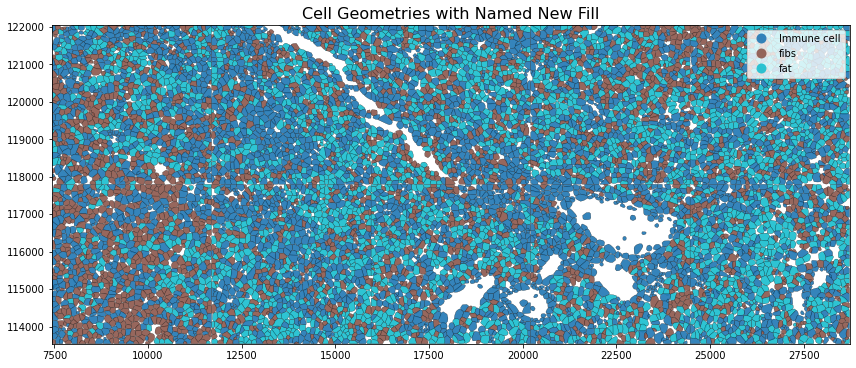

In [20]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

# Convert the 'geometry' column to proper geometric objects if needed (commented as your data seems already converted)
#combined_df['geometry'] = combined_df['geometry'].apply(wkt.loads)

# Convert the combined DataFrame into a GeoDataFrame
gdf_combined = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Remove any rows where 'cell' starts with '0_'
gdf_combined = gdf_combined[~gdf_combined['cell'].astype(str).str.startswith('0_')]

# Check the first few rows to make sure the data is as expected
print(gdf_combined.head())  # Debug step: see if the data looks correct

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 12))

# Set the axis background to white
ax.set_facecolor('white')

# Plot the geometries with fill based on 'cell_types' column
gdf_combined.plot(ax=ax, column="cell_type", alpha=0.9, legend=True, edgecolor='black', linewidth=0.25)

# Customize the title and other aesthetics
ax.set_title('Cell Geometries with Named New Fill', color='black', fontsize=16)

# Set the figure background to transparent (optional)
fig.patch.set_alpha(0)

# Set limits and aspect ratio for better visualization
ax.set_xlim(gdf_combined.total_bounds[[0, 2]])  # x limits
ax.set_ylim(gdf_combined.total_bounds[[1, 3]])  # y limits
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()

## Now lets plot cells and show specific transcripts for a gene of interest

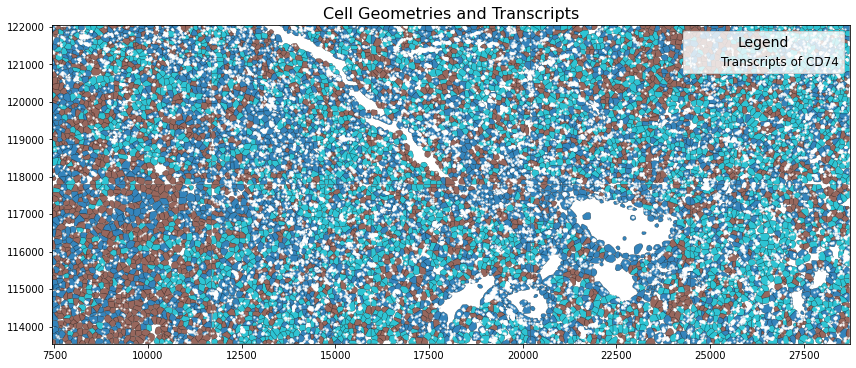

In [21]:

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

gdf_combined = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Remove any rows where 'cell' starts with '0_'
gdf_combined = gdf_combined[~gdf_combined['cell'].astype(str).str.startswith('0_')]

# Load the transcripts (tx) file
# Example format: 'gene', 'x', 'y'
combined_FOVs = pd.concat(fovs, ignore_index=True)

# Filter for a specific gene of interest
gene_of_interest = "CD74"  # Replace with your gene of interest
tx_filtered = combined_FOVs[combined_FOVs['target'] == gene_of_interest]

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 12))

# Set the axis background to white
ax.set_facecolor('white')

# Plot the cell geometries with fill based on 'cell_types' column
gdf_combined.plot(ax=ax, column="cell_type", alpha=0.9, legend=True, edgecolor='black', linewidth=0.25)

# Plot the transcripts as white dots
ax.scatter(
    tx_filtered['x'],  # X-coordinates
    tx_filtered['y'],  # Y-coordinates
    color='white', 
    s=2, alpha=0.6,
    label=f'Transcripts of {gene_of_interest}'
)

# Customize the title and other aesthetics
ax.set_title('Cell Geometries and Transcripts', color='black', fontsize=16)
ax.legend(title="Legend", fontsize=12, title_fontsize=14, loc='upper right')

# Set the figure background to transparent (optional)
fig.patch.set_alpha(0)

# Set limits and aspect ratio for better visualization
ax.set_xlim(gdf_combined.total_bounds[[0, 2]])  # x limits
ax.set_ylim(gdf_combined.total_bounds[[1, 3]])  # y limits
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()


## Next for proximity enrichment, calculate the mean diameter (in this case in px of 10 cells)

In [33]:
combined_df["area"] = combined_df["geometry"].apply(lambda x: x.area)
combined_df["diameter"] = 2 * np.sqrt(combined_df["area"] / np.pi)
combined_df["centroid"] = combined_df["geometry"].apply(lambda x: x.centroid)
combined_df["centroid_x"] = combined_df["centroid"].apply(lambda x: x.x)
combined_df["centroid_y"] = combined_df["centroid"].apply(lambda x: x.y)
combined_df = combined_df.drop(columns=["centroid"])
cells_df = combined_df[~combined_df['cell'].astype(str).str.startswith('0_')]
mean_diameter=cells_df['diameter'].mean() * 10
print(f"Mean diameter: {mean_diameter:.2f}")

Mean diameter: 1347.21


In [35]:
cells_df

cell                                           geometry  \
1     1000_1  POLYGON ((11482.5 118526.633, 11496.6 118528.1...   
2     1001_1  POLYGON ((10541.5 118510.847, 10566.31 118510....   
3     1002_1  POLYGON ((11229.31 118490.019, 11231.1 118491....   
4     1003_1  POLYGON ((10448.05 118498.185, 10455.809 11850...   
5     1004_1  POLYGON ((7737.2 118452.833, 7737.2 118459.136...   
...      ...                                                ...   
1022  997_10  POLYGON ((27811.321 113658.857, 27813.019 1136...   
1023  998_10  POLYGON ((28028.251 113612.268, 28031.749 1136...   
1024  999_10  POLYGON ((28212.409 113681.169, 28251.579 1137...   
1025   99_10  POLYGON ((25500.599 117449.516, 25503.86 11745...   
1026    9_10  POLYGON ((26321.25 117667.318, 26305.18 117731...   

      num_transcripts    cell_type          area    diameter    centroid_x  \
1                1673  Immune cell  27515.423842  187.172983  11461.351072   
2                 953         fibs  20356.643421  160.993427  10609.541879   
3                1033  Immune cell  24312.411760  175.941820  11279.656834   
4                 476         fibs   6681.015323   92.230867  10482.554730   
5                 326         fibs   7462.265825   97.474366   7786.169428   
...               ...          ...           ...         ...           ...   
1022             1409          fat  25105.771300  178.789432  27899.959491   
1023              925  Immune cell  18198.200241  152.219145  28088.816769   
1024              393         fibs   6673.574360   92.179492  28265.065396   
1025             1033  Immune cell  16051.712028  142.960395  25555.092170   
1026             1525  Immune cell  28319.022800  189.886544  26413.562827   

         centroid_y  
1     118435.513986  
2     118431.538121  
3     118409.329898  
4     118458.427075  
5     118464.510604  
...             ...  
1022  113629.713602  
1023  113631.487331  
1024  113668.370453  
1025  117415.166289  
1026  117728.121298  

[10958 rows x 8 columns]

## Next caclualate proximity enrichment score

In [38]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Assuming you have a DataFrame `cells_df` with columns 'x_global_px', 'y_global_px', and 'cell_types'
# You can adjust the radius as needed
radius = mean_diameter # avergare px radius/cell is 70 ie. diameter of 140, so take an average of 10 cells away

cells_df = cells_df.dropna()

# Create a KD-Tree for fast nearest-neighbor search
tree = cKDTree(cells_df[['centroid_x', 'centroid_y']].values)

# List unique cell types
cell_types = cells_df['cell_type'].unique()

# Initialize a results dictionary
proximity_scores = {cell_type: {} for cell_type in cell_types}

# Iterate over each cell type
for focal_type in cell_types:
    focal_cells = cells_df[cells_df['cell_type'] == focal_type]
    
    # Iterate over each other cell type
    for target_type in cell_types:
        target_cells = cells_df[cells_df['cell_type'] == target_type]

        # Get coordinates of focal and target cells
        focal_coords = focal_cells[['centroid_x', 'centroid_y']].values
        target_coords = target_cells[['centroid_x', 'centroid_y']].values
        
        # Query KDTree to find number of target cells within the radius for each focal cell
        neighbors_within_radius = tree.query_ball_point(focal_coords, radius)
        
        # Count occurrences of target cells within the radius
        target_counts = [np.sum(cells_df.index[neighbors].isin(target_cells.index)) for neighbors in neighbors_within_radius]
        
        # Normalize the count by total number of target cells
        avg_count = np.mean(target_counts) / len(target_cells)

        # Store in the result dictionary
        proximity_scores[focal_type][target_type] = avg_count

# Convert to DataFrame for easier Z-score calculation
proximity_df = pd.DataFrame(proximity_scores)

# Calculate Z-scores by standardizing the matrix
z_scores = (proximity_df - proximity_df.mean()) / proximity_df.std()

In [39]:
z_scores

Immune cell      fibs       fat
Immune cell    -1.152205 -1.152643 -1.150765
fibs            0.510393  0.516654  0.492890
fat             0.641812  0.635990  0.657875

## Now plot this in a heatmap- this example is a little lame as there are only a few cell types, but with more this should give a nice plot

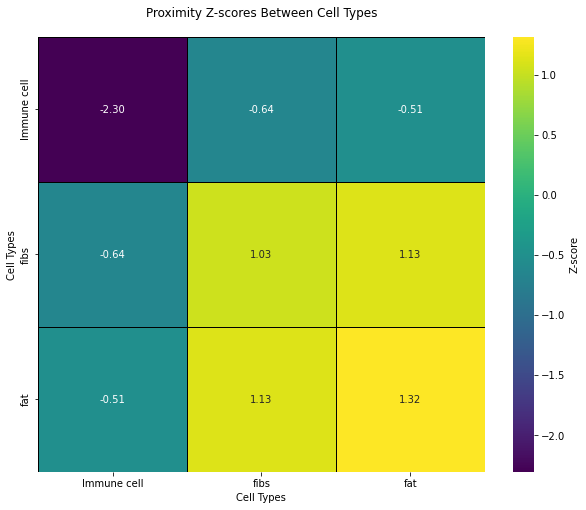

In [40]:
# Plotting the heatmap of Z-scores
plt.figure(figsize=(10, 8))
sns.heatmap(
    (z_scores + z_scores.T),
    cmap="viridis",           # Use the viridis colormap
    annot=True,               # Annotate cells with the Z-scores
    fmt=".2f",                # Format annotations with 2 decimal points
    linewidths=.5,           # Add space between grid lines
    linecolor='black',        # Black grid lines
    cbar_kws={"label": "Z-score"},  # Colorbar label
)

plt.title("Proximity Z-scores Between Cell Types", pad=20)
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.show()